In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.models as models
from torchvision.transforms import v2
from tqdm import tqdm
from PIL import Image
import os
import matplotlib.pyplot as plt
import copy

### VGG16 Architecture

| Index | Layer Name | Layer Type |
|--------|------------|------------|
| 0  | conv1_1  | Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  |
| 1  | relu1_1  | ReLU(inplace=True)  |
| 2  | conv1_2  | Conv2d(64, 64, kernel_size=3, stride=1, padding=1)  |
| 3  | relu1_2  | ReLU(inplace=True)  |
| 4  | pool1  | MaxPool2d(kernel_size=2, stride=2)  |
| 5  | conv2_1  | Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  |
| 6  | relu2_1  | ReLU(inplace=True)  |
| 7  | conv2_2  | Conv2d(128, 128, kernel_size=3, stride=1, padding=1)  |
| 8  | relu2_2  | ReLU(inplace=True)  |
| 9  | pool2  | MaxPool2d(kernel_size=2, stride=2)  |
| 10 | conv3_1  | Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  |
| 11 | relu3_1  | ReLU(inplace=True)  |
| 12 | conv3_2  | Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  |
| 13 | relu3_2  | ReLU(inplace=True)  |
| 14 | conv3_3  | Conv2d(256, 256, kernel_size=3, stride=1, padding=1)  |
| 15 | relu3_3  | ReLU(inplace=True)  |
| 16 | pool3  | MaxPool2d(kernel_size=2, stride=2)  |
| 17 | conv4_1  | Conv2d(256, 512, kernel_size=3, stride=1, padding=1)  |
| 18 | relu4_1  | ReLU(inplace=True)  |
| 19 | conv4_2  | Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  |
| 20 | relu4_2  | ReLU(inplace=True)  |
| 21 | conv4_3  | Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  |
| 22 | relu4_3  | ReLU(inplace=True)  |
| 23 | pool4  | MaxPool2d(kernel_size=2, stride=2)  |
| 24 | conv5_1  | Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  |
| 25 | relu5_1  | ReLU(inplace=True)  |
| 26 | conv5_2  | Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  |
| 27 | relu5_2  | ReLU(inplace=True)  |
| 28 | conv5_3  | Conv2d(512, 512, kernel_size=3, stride=1, padding=1)  |
| 29 | relu5_3  | ReLU(inplace=True)  |
| 30 | pool5  | MaxPool2d(kernel_size=2, stride=2)  |


In [2]:
class VGG16(nn.Module):
    def __init__(self, pool_type="avg"):
        super().__init__()
        self.layer_list = []
        self.vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        if pool_type == "avg":
            for layer in self.vgg16:
                if isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
                    self.layer_list.append(
                        nn.AvgPool2d(
                            kernel_size=2, stride=2, padding=0, ceil_mode=False
                        )
                    )
                else:
                    self.layer_list.append(layer)
            self.final_model = nn.Sequential(*self.layer_list)
        else:
            self.final_model = models.vgg16(
                weights=models.VGG16_Weights.IMAGENET1K_V1
            ).features

        for param in self.final_model.parameters():
            param.requires_grad = False

    def forward(self, input, layer_keys):
        out = {}
        last_layer_key = str(max([int(key) for key in layer_keys]))
        for name, layer in self.final_model.named_children():
            out[name] = layer(input)
            input = out[name]
            if name == last_layer_key:
                break

        final_output = {k: out[k] for k in layer_keys}
        return final_output

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.reflection_pad = torch.nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=0)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=0)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)

    def forward(self, x):
        residual = x
        out = self.reflection_pad(x)
        out = self.conv1(out)
        out = self.in1(out)
        out = self.relu(out)
        out = self.reflection_pad(out)
        out = self.conv2(out)
        out = self.in2(out)
        out += residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(
                x_in, mode="nearest", scale_factor=self.upsample
            )
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


class ImageTransformationNetwork(nn.Module):
    def __init__(self):
        super(ImageTransformationNetwork, self).__init__()
        self.ref_pad1 = nn.ReflectionPad2d(padding=4)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=9, stride=1)
        self.in1 = nn.InstanceNorm2d(32, affine=True)

        self.ref_pad2 = nn.ReflectionPad2d(padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2)
        self.in2 = nn.InstanceNorm2d(64, affine=True)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.in3 = nn.InstanceNorm2d(128, affine=True)

        self.residuals = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
        )

        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = nn.InstanceNorm2d(32, affine=True)

        self.deconv3 = UpsampleConvLayer(32, 3, kernel_size=9, stride=1)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.ref_pad1(x)
        x = self.relu(self.in1(self.conv1(x)))

        x = self.ref_pad2(x)
        x = self.relu(self.in2(self.conv2(x)))

        x = self.ref_pad2(x)
        x = self.relu(self.in3(self.conv3(x)))

        x = self.residuals(x)

        x = self.relu(self.in4(self.deconv1(x)))
        x = self.relu(self.in5(self.deconv2(x)))
        x = self.deconv3(x)
        return x

        """
        ref: http://distill.pub/2016/deconv-checkerboard/
        """


In [4]:
class ImageDataset(Dataset):
    def __init__(self, folder_path, resize_value=256):
        self.folder_path = folder_path
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith((".png", ".jpg", ".jpeg"))
        ]
        self.resize_value = resize_value

    @staticmethod
    def load_and_transform(image_path, resize_value):
        image = Image.open(image_path).convert("RGB")
        transformations = v2.Compose(
            [
                v2.Resize((resize_value, resize_value)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=False),
            ]
        )
        return transformations(image)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_tensor = self.load_and_transform(image_path, self.resize_value)
        return image_tensor

In [5]:
class Trainer:
    def __init__(
        self,
        lr=0.001,
        batch_size=4,
        num_epochs=1,
        alpha=1e5,
        beta=1e10,
        seed=42,
        content_folder=r"test2017/test2017",
        style_path=r"Styles/the-starry-night.jpg",
        resize_value=256,
        style_resize_value=512,
        device="cuda" if torch.cuda.is_available() else "cpu",
        content_layer=["8"],
        style_layers=[str(i) for i in [3, 8, 15, 22]],
    ):
        print("[DEBUG] Initializing Trainer...")
        self.seed = seed
        self.lr = lr
        self.num_epochs = num_epochs
        self.beta = beta
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        self.batch_size = batch_size
        self.content_layer = content_layer
        self.seed = seed
        self.style_layers = style_layers
        self.device = device
        print(f"[DEBUG] Using device: {self.device}")

        self.loss_net = VGG16(pool_type="max").to(self.device).eval()
        print("[DEBUG] loss_net (VGG16) initialized.")

        self.style_image = (
            ImageDataset.load_and_transform(style_path, style_resize_value)
            .unsqueeze(0)
            .to(self.device)
        )

        self.img_transform_net = ImageTransformationNetwork().to(device)
        print("[DEBUG] img_transform_net initialized.")

        self.dataset, self.dataloader = self._get_dataloader(
            folder_path=content_folder,
            resize_value=resize_value,
            batch_size=self.batch_size,
        )
        print(
            f"[DEBUG] Dataset and DataLoader created. Dataset length: {len(self.dataset)}"
        )
        self.optimizer = optim.Adam(self.img_transform_net.parameters(), lr=self.lr)
        print("[DEBUG] Optimizer initialized.")

    @staticmethod
    def _get_dataloader(folder_path, resize_value, batch_size):
        print("[DEBUG] Creating ImageDataset and DataLoader...")
        dataset = ImageDataset(folder_path=folder_path, resize_value=resize_value)
        dataloader = DataLoader(dataset, batch_size=batch_size)
        print(f"[DEBUG] DataLoader created with batch_size = {batch_size}")
        return dataset, dataloader

    def vgg_transform(self, input):
        mean = torch.tensor([0.485, 0.456, 0.406], device=self.device).view(-1, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=self.device).view(-1, 1, 1)
        input = torch.div(input, 255.0)
        normalized = (input - mean) / std
        return normalized

    def get_gram_matrix(self, input):
        batch, channel, height, width = input.shape
        reshaped_input = input.view(batch, channel, height * width)
        gram_matrix = torch.bmm(reshaped_input, reshaped_input.transpose(1, 2)) / (
            channel * height * width
        )
        return gram_matrix

    def get_content_loss(self, output, target):
        loss = self.mse_loss(output, target)
        return loss

    def get_style_loss(self, outputs, target_gram_matrices):
        style_loss = 0
        for output, G_target in zip(outputs, target_gram_matrices):
            G = self.get_gram_matrix(output)
            target_gram_matrix = G_target.repeat(G.shape[0], 1, 1)
            style_loss = style_loss + self.mse_loss(G, target_gram_matrix)
        return style_loss

    def train(self, checkpoint_dir="checkpoints_"):
        np.random.seed(self.seed)
        torch.manual_seed(self.seed)
        os.makedirs(checkpoint_dir, exist_ok=True)

        self.img_transform_net.train()
        self.loss_net.eval()

        style_image = self.vgg_transform(self.style_image)
        style_targets = self.loss_net(style_image, self.style_layers)

        target_gram_matrices = [
            self.get_gram_matrix(style_targets[key]) for key in self.style_layers
        ]

        scheduler = torch.optim.lr_scheduler.StepLR(
            self.optimizer, step_size=10000, gamma=0.8
        )
        print("[DEBUG] Scheduler initialized.")

        global_iter = 0

        history = {"content_loss": [], "style_loss": [], "total_loss": []}

        for epoch in range(self.num_epochs):
            print("*" * 10 + f" Epoch - {epoch + 1} " + "*" * 10)

            progress_bar = tqdm(
                self.dataloader,
                desc="Optimizing",
                unit="batch",
                leave=True,
                dynamic_ncols=True,
            )
            agg_content_loss = agg_style_loss = 0
            for idx, input_images in enumerate(progress_bar):
                X = input_images.to(self.device)
                self.optimizer.zero_grad()
                y = self.img_transform_net(X)

                y = self.vgg_transform(y)
                X = self.vgg_transform(X)

                y_rep = self.loss_net(y, self.content_layer + self.style_layers)

                y_content_rep = y_rep[self.content_layer[0]]
                content_target_rep = self.loss_net(X, self.content_layer).get(
                    self.content_layer[0]
                )

                content_loss = self.alpha * self.get_content_loss(
                    y_content_rep, content_target_rep
                )

                y_style_rep = [y_rep[key] for key in self.style_layers]
                style_loss = self.beta * self.get_style_loss(
                    y_style_rep, target_gram_matrices
                )

                total_loss = content_loss + style_loss
                total_loss.backward()

                self.optimizer.step()
                agg_content_loss += content_loss.item()
                agg_style_loss += style_loss.item()

                progress_bar.set_postfix(
                    {
                        "content_loss": agg_content_loss / (idx + 1),
                        "style_loss": agg_style_loss / (idx + 1),
                        "total_loss": (agg_content_loss + agg_style_loss) / (idx + 1),
                    },
                    refresh=True,
                )
                history["content_loss"].append(agg_content_loss / (idx + 1))
                history["style_loss"].append(agg_style_loss / (idx + 1))
                history["total_loss"].append(
                    (agg_content_loss + agg_style_loss) / (idx + 1)
                )

                global_iter += 1
                scheduler.step()
                if global_iter % 2000 == 0:
                    checkpoint_path = os.path.join(
                        checkpoint_dir, f"model_epoch_{epoch + 1}.pth"
                    )

                    self.img_transform_net.eval().cpu()

                    torch.save(
                        {
                            "epoch": epoch + 1,
                            "model_state_dict": self.img_transform_net.state_dict(),
                            "optimizer_state_dict": self.optimizer.state_dict(),
                            "loss": history["total_loss"][-1],
                        },
                        checkpoint_path,
                    )
                    print(f"Checkpoint saved at {checkpoint_path}")
                    current_lr = scheduler.get_last_lr()[0]
                    print(
                        f"Iteration {global_iter}: Adjusted learning rate to {current_lr:.6f}"
                    )

                    self.img_transform_net.to(self.device).train()

                if (idx + 1) % 500 == 0:
                    print(
                        f"Epoch {epoch + 1}, Batch {idx + 1}: Content Loss: {agg_content_loss / (idx + 1)}, Style Loss: {agg_style_loss / (idx + 1)}, Total Loss: {(agg_content_loss + agg_style_loss) / (idx + 1)}"
                    )

        plt.figure(figsize=(10, 5))
        plt.plot(history["content_loss"], label="Content Loss", alpha=0.7)
        plt.plot(history["style_loss"], label="Style Loss", alpha=0.7)
        plt.plot(history["total_loss"], label="Total Loss", alpha=0.7)
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.yscale("log")
        plt.title("Training Loss Curves (Log Scale)")
        plt.legend()
        plt.grid(True, which="both", linestyle="--")
        plt.show()

        return self.img_transform_net, history


In [6]:
trainer = Trainer(
    lr=0.001,
    batch_size=4,
    num_epochs=2,
    alpha=1e5,
    beta=1e10,
    content_folder=r"/kaggle/input/coco-test2017/test2017",
    style_path=r"/kaggle/input/nst-dataset/Styles/868625.jpg",
    resize_value=256,
    style_resize_value=512,
    device="cuda" if torch.cuda.is_available() else "cpu",
    content_layer=["8"],
    style_layers=[str(i) for i in [3, 8, 15, 22]],
)

[DEBUG] Initializing Trainer...
[DEBUG] Using device: cuda


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s] 


[DEBUG] loss_net (VGG16) initialized.
[DEBUG] img_transform_net initialized.
[DEBUG] Creating ImageDataset and DataLoader...
[DEBUG] DataLoader created with batch_size = 4
[DEBUG] Dataset and DataLoader created. Dataset length: 40670
[DEBUG] Optimizer initialized.


[DEBUG] Scheduler initialized.
********** Epoch - 1 **********


Optimizing:   5%|▍         | 501/10168 [01:34<29:33,  5.45batch/s, content_loss=4.52e+5, style_loss=2.6e+5, total_loss=7.12e+5] 

Epoch 1, Batch 500: Content Loss: 451912.6405625, Style Loss: 260536.9654765625, Total Loss: 712449.6060390625


Optimizing:  10%|▉         | 1001/10168 [03:07<29:53,  5.11batch/s, content_loss=3.94e+5, style_loss=1.67e+5, total_loss=5.61e+5]

Epoch 1, Batch 1000: Content Loss: 393845.792578125, Style Loss: 167220.03540234375, Total Loss: 561065.8279804687


Optimizing:  15%|█▍        | 1500/10168 [04:40<26:43,  5.41batch/s, content_loss=3.58e+5, style_loss=1.36e+5, total_loss=4.95e+5]

Epoch 1, Batch 1500: Content Loss: 358353.63865625, Style Loss: 136388.52763541666, Total Loss: 494742.1662916667


Optimizing:  20%|█▉        | 2001/10168 [06:15<26:48,  5.08batch/s, content_loss=3.36e+5, style_loss=1.21e+5, total_loss=4.57e+5]

Checkpoint saved at checkpoints_/model_epoch_1.pth
Iteration 2000: Adjusted learning rate to 0.001000
Epoch 1, Batch 2000: Content Loss: 336197.623140625, Style Loss: 121199.11671875, Total Loss: 457396.739859375


Optimizing:  25%|██▍       | 2501/10168 [07:48<23:23,  5.46batch/s, content_loss=3.21e+5, style_loss=1.12e+5, total_loss=4.33e+5]

Epoch 1, Batch 2500: Content Loss: 320661.30269375, Style Loss: 111994.003959375, Total Loss: 432655.306653125


Optimizing:  30%|██▉       | 3001/10168 [09:21<22:09,  5.39batch/s, content_loss=3.08e+5, style_loss=1.06e+5, total_loss=4.14e+5]

Epoch 1, Batch 3000: Content Loss: 308225.7670625, Style Loss: 105561.97333203125, Total Loss: 413787.7403945312


Optimizing:  34%|███▍      | 3501/10168 [10:54<20:39,  5.38batch/s, content_loss=2.98e+5, style_loss=1.01e+5, total_loss=3.99e+5]

Epoch 1, Batch 3500: Content Loss: 298310.3663102679, Style Loss: 100922.21048772322, Total Loss: 399232.57679799106


Optimizing:  39%|███▉      | 4001/10168 [12:27<20:44,  4.96batch/s, content_loss=2.91e+5, style_loss=9.74e+4, total_loss=3.88e+5]

Checkpoint saved at checkpoints_/model_epoch_1.pth
Iteration 4000: Adjusted learning rate to 0.001000
Epoch 1, Batch 4000: Content Loss: 290766.2059570312, Style Loss: 97417.56351953125, Total Loss: 388183.7694765625


Optimizing:  44%|████▍     | 4501/10168 [14:01<17:57,  5.26batch/s, content_loss=2.84e+5, style_loss=9.46e+4, total_loss=3.79e+5]

Epoch 1, Batch 4500: Content Loss: 284446.0321388889, Style Loss: 94643.29698697917, Total Loss: 379089.32912586804


Optimizing:  49%|████▉     | 5001/10168 [15:36<15:56,  5.40batch/s, content_loss=2.79e+5, style_loss=9.24e+4, total_loss=3.72e+5]

Epoch 1, Batch 5000: Content Loss: 279204.32251875, Style Loss: 92375.40709765625, Total Loss: 371579.72961640626


Optimizing:  54%|█████▍    | 5501/10168 [17:10<14:14,  5.46batch/s, content_loss=2.75e+5, style_loss=9.05e+4, total_loss=3.65e+5]

Epoch 1, Batch 5500: Content Loss: 274760.090484375, Style Loss: 90550.57903053977, Total Loss: 365310.6695149148


Optimizing:  59%|█████▉    | 6001/10168 [18:43<13:56,  4.98batch/s, content_loss=2.71e+5, style_loss=8.9e+4, total_loss=3.6e+5]  

Checkpoint saved at checkpoints_/model_epoch_1.pth
Iteration 6000: Adjusted learning rate to 0.001000
Epoch 1, Batch 6000: Content Loss: 270984.6789270833, Style Loss: 88982.4670670573, Total Loss: 359967.14599414065


Optimizing:  64%|██████▍   | 6501/10168 [20:16<11:21,  5.38batch/s, content_loss=2.68e+5, style_loss=8.77e+4, total_loss=3.55e+5]

Epoch 1, Batch 6500: Content Loss: 267603.17920432694, Style Loss: 87671.87750060097, Total Loss: 355275.0567049279


Optimizing:  69%|██████▉   | 7001/10168 [21:51<09:38,  5.48batch/s, content_loss=2.64e+5, style_loss=8.65e+4, total_loss=3.51e+5]

Epoch 1, Batch 7000: Content Loss: 264376.808015625, Style Loss: 86465.18919140624, Total Loss: 350841.99720703124


Optimizing:  74%|███████▍  | 7501/10168 [23:24<08:02,  5.53batch/s, content_loss=2.62e+5, style_loss=8.54e+4, total_loss=3.47e+5]

Epoch 1, Batch 7500: Content Loss: 261621.20991145834, Style Loss: 85432.2792546875, Total Loss: 347053.48916614585


Optimizing:  79%|███████▊  | 8001/10168 [24:57<07:10,  5.04batch/s, content_loss=2.59e+5, style_loss=8.45e+4, total_loss=3.43e+5]

Checkpoint saved at checkpoints_/model_epoch_1.pth
Iteration 8000: Adjusted learning rate to 0.001000
Epoch 1, Batch 8000: Content Loss: 258994.68795214844, Style Loss: 84502.43235205078, Total Loss: 343497.1203041992


Optimizing:  84%|████████▎ | 8500/10168 [26:30<05:05,  5.46batch/s, content_loss=2.57e+5, style_loss=8.37e+4, total_loss=3.41e+5]

Epoch 1, Batch 8500: Content Loss: 256858.34665900737, Style Loss: 83690.281734375, Total Loss: 340548.62839338236


Optimizing:  89%|████████▊ | 9001/10168 [28:02<03:32,  5.50batch/s, content_loss=2.55e+5, style_loss=8.29e+4, total_loss=3.38e+5]

Epoch 1, Batch 9000: Content Loss: 254612.21735677082, Style Loss: 82923.38711197917, Total Loss: 337535.60446875


Optimizing:  93%|█████████▎| 9501/10168 [29:36<02:03,  5.40batch/s, content_loss=2.53e+5, style_loss=8.22e+4, total_loss=3.35e+5]

Epoch 1, Batch 9500: Content Loss: 252675.54740460525, Style Loss: 82234.74307483553, Total Loss: 334910.29047944077


Optimizing:  98%|█████████▊| 10001/10168 [31:09<00:33,  4.93batch/s, content_loss=2.51e+5, style_loss=8.16e+4, total_loss=3.33e+5]

Checkpoint saved at checkpoints_/model_epoch_1.pth
Iteration 10000: Adjusted learning rate to 0.000800
Epoch 1, Batch 10000: Content Loss: 250997.80869609374, Style Loss: 81639.75787109375, Total Loss: 332637.5665671875


Optimizing: 100%|██████████| 10168/10168 [31:40<00:00,  5.35batch/s, content_loss=2.5e+5, style_loss=8.14e+4, total_loss=3.32e+5] 


********** Epoch - 2 **********


Optimizing:   5%|▍         | 501/10168 [01:22<26:04,  6.18batch/s, content_loss=2.17e+5, style_loss=6.91e+4, total_loss=2.86e+5]

Epoch 2, Batch 500: Content Loss: 216479.19778125, Style Loss: 69124.0639921875, Total Loss: 285603.2617734375


Optimizing:  10%|▉         | 1001/10168 [02:44<26:04,  5.86batch/s, content_loss=2.17e+5, style_loss=6.94e+4, total_loss=2.86e+5]

Epoch 2, Batch 1000: Content Loss: 216937.9105, Style Loss: 69374.418578125, Total Loss: 286312.329078125


Optimizing:  15%|█▍        | 1501/10168 [04:06<24:08,  5.98batch/s, content_loss=2.15e+5, style_loss=6.91e+4, total_loss=2.85e+5]

Epoch 2, Batch 1500: Content Loss: 215430.74321875, Style Loss: 69129.6194609375, Total Loss: 284560.3626796875


Optimizing:  18%|█▊        | 1833/10168 [05:01<24:04,  5.77batch/s, content_loss=2.15e+5, style_loss=6.91e+4, total_loss=2.84e+5]

Checkpoint saved at checkpoints_/model_epoch_2.pth
Iteration 12000: Adjusted learning rate to 0.000800


Optimizing:  20%|█▉        | 2001/10168 [05:28<21:59,  6.19batch/s, content_loss=2.15e+5, style_loss=6.91e+4, total_loss=2.85e+5]

Epoch 2, Batch 2000: Content Loss: 215444.57125, Style Loss: 69130.74416015625, Total Loss: 284575.31541015627


Optimizing:  25%|██▍       | 2501/10168 [06:50<21:09,  6.04batch/s, content_loss=2.16e+5, style_loss=6.91e+4, total_loss=2.85e+5]

Epoch 2, Batch 2500: Content Loss: 215493.166215625, Style Loss: 69131.7256875, Total Loss: 284624.891903125


Optimizing:  30%|██▉       | 3001/10168 [08:12<19:46,  6.04batch/s, content_loss=2.15e+5, style_loss=6.9e+4, total_loss=2.84e+5] 

Epoch 2, Batch 3000: Content Loss: 214882.45470833333, Style Loss: 68968.8086640625, Total Loss: 283851.2633723958


Optimizing:  34%|███▍      | 3501/10168 [09:34<17:53,  6.21batch/s, content_loss=2.14e+5, style_loss=6.88e+4, total_loss=2.83e+5]

Epoch 2, Batch 3500: Content Loss: 214087.977625, Style Loss: 68835.40052455357, Total Loss: 282923.37814955355


Optimizing:  38%|███▊      | 3833/10168 [10:28<18:55,  5.58batch/s, content_loss=2.14e+5, style_loss=6.88e+4, total_loss=2.83e+5]

Checkpoint saved at checkpoints_/model_epoch_2.pth
Iteration 14000: Adjusted learning rate to 0.000800


Optimizing:  39%|███▉      | 4001/10168 [10:55<16:49,  6.11batch/s, content_loss=2.14e+5, style_loss=6.87e+4, total_loss=2.83e+5]

Epoch 2, Batch 4000: Content Loss: 213786.10175976562, Style Loss: 68742.82517089843, Total Loss: 282528.92693066405


Optimizing:  44%|████▍     | 4501/10168 [12:17<15:26,  6.12batch/s, content_loss=2.13e+5, style_loss=6.87e+4, total_loss=2.82e+5]

Epoch 2, Batch 4500: Content Loss: 213489.69355381944, Style Loss: 68665.6648984375, Total Loss: 282155.35845225694


Optimizing:  49%|████▉     | 5001/10168 [13:39<13:53,  6.20batch/s, content_loss=2.13e+5, style_loss=6.86e+4, total_loss=2.82e+5]

Epoch 2, Batch 5000: Content Loss: 213328.4931296875, Style Loss: 68612.5153890625, Total Loss: 281941.00851875


Optimizing:  54%|█████▍    | 5501/10168 [15:01<12:36,  6.17batch/s, content_loss=2.13e+5, style_loss=6.86e+4, total_loss=2.82e+5]

Epoch 2, Batch 5500: Content Loss: 213160.07284801136, Style Loss: 68574.69006036932, Total Loss: 281734.76290838065


Optimizing:  57%|█████▋    | 5833/10168 [15:55<12:58,  5.57batch/s, content_loss=2.13e+5, style_loss=6.86e+4, total_loss=2.82e+5]

Checkpoint saved at checkpoints_/model_epoch_2.pth
Iteration 16000: Adjusted learning rate to 0.000800


Optimizing:  59%|█████▉    | 6001/10168 [16:23<11:22,  6.11batch/s, content_loss=2.13e+5, style_loss=6.85e+4, total_loss=2.82e+5]

Epoch 2, Batch 6000: Content Loss: 213157.08604036458, Style Loss: 68547.65875195313, Total Loss: 281704.7447923177


Optimizing:  64%|██████▍   | 6501/10168 [17:44<10:15,  5.96batch/s, content_loss=2.13e+5, style_loss=6.85e+4, total_loss=2.82e+5]

Epoch 2, Batch 6500: Content Loss: 213043.49471634615, Style Loss: 68534.2795234375, Total Loss: 281577.77423978364


Optimizing:  69%|██████▉   | 7001/10168 [19:06<08:33,  6.17batch/s, content_loss=2.13e+5, style_loss=6.85e+4, total_loss=2.81e+5]

Epoch 2, Batch 7000: Content Loss: 212738.38635825893, Style Loss: 68470.96703236607, Total Loss: 281209.353390625


Optimizing:  74%|███████▍  | 7501/10168 [20:28<07:15,  6.12batch/s, content_loss=2.13e+5, style_loss=6.84e+4, total_loss=2.81e+5]

Epoch 2, Batch 7500: Content Loss: 212580.74699166667, Style Loss: 68428.7987390625, Total Loss: 281009.5457307292


Optimizing:  77%|███████▋  | 7833/10168 [21:22<06:56,  5.61batch/s, content_loss=2.12e+5, style_loss=6.84e+4, total_loss=2.81e+5]

Checkpoint saved at checkpoints_/model_epoch_2.pth
Iteration 18000: Adjusted learning rate to 0.000800


Optimizing:  79%|███████▊  | 8001/10168 [21:50<06:09,  5.86batch/s, content_loss=2.12e+5, style_loss=6.84e+4, total_loss=2.81e+5]

Epoch 2, Batch 8000: Content Loss: 212299.0992392578, Style Loss: 68383.0602578125, Total Loss: 280682.1594970703


Optimizing:  84%|████████▎ | 8501/10168 [23:12<04:28,  6.21batch/s, content_loss=2.12e+5, style_loss=6.83e+4, total_loss=2.81e+5]

Epoch 2, Batch 8500: Content Loss: 212237.79249816175, Style Loss: 68347.89219347427, Total Loss: 280585.684691636


Optimizing:  89%|████████▊ | 9001/10168 [24:34<03:11,  6.11batch/s, content_loss=2.12e+5, style_loss=6.83e+4, total_loss=2.8e+5] 

Epoch 2, Batch 9000: Content Loss: 211907.7049565972, Style Loss: 68283.53434592014, Total Loss: 280191.2393025174


Optimizing:  93%|█████████▎| 9501/10168 [25:56<01:49,  6.10batch/s, content_loss=2.12e+5, style_loss=6.82e+4, total_loss=2.8e+5]

Epoch 2, Batch 9500: Content Loss: 211716.67971792762, Style Loss: 68236.31027261513, Total Loss: 279952.98999054276


Optimizing:  97%|█████████▋| 9833/10168 [26:50<00:59,  5.66batch/s, content_loss=2.12e+5, style_loss=6.82e+4, total_loss=2.8e+5]

Checkpoint saved at checkpoints_/model_epoch_2.pth
Iteration 20000: Adjusted learning rate to 0.000640


Optimizing:  98%|█████████▊| 10001/10168 [27:17<00:27,  6.18batch/s, content_loss=2.12e+5, style_loss=6.82e+4, total_loss=2.8e+5]

Epoch 2, Batch 10000: Content Loss: 211626.54936328126, Style Loss: 68213.71092539062, Total Loss: 279840.2602886719


Optimizing: 100%|██████████| 10168/10168 [27:44<00:00,  6.11batch/s, content_loss=2.12e+5, style_loss=6.82e+4, total_loss=2.8e+5]


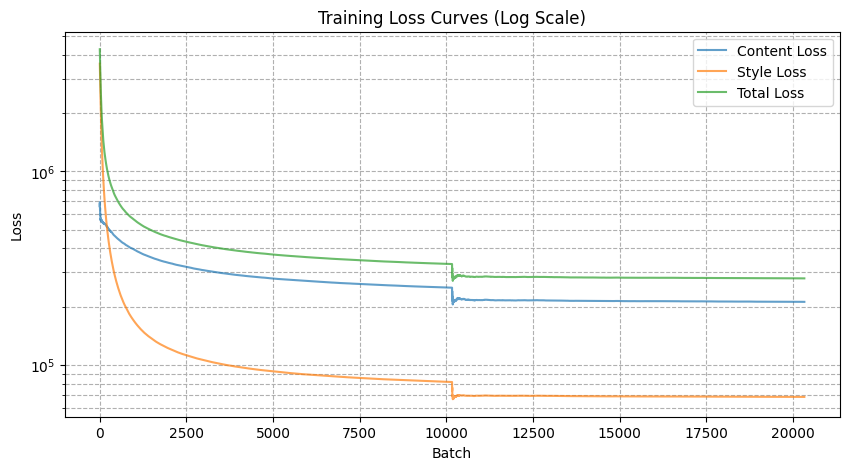

In [7]:
transform_net, history = trainer.train()

In [8]:
def save_image(filename, data):
    img = data.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = Image.fromarray(img)
    img.save(filename)

In [9]:
def stylize(
    model_path, content_image_path, output_image_path, cuda=True, export_onnx=None
):
    device = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
    content_image = ImageDataset.load_and_transform(content_image_path, 1080)

    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        style_model = ImageTransformationNetwork()
        checkpoint = torch.load(model_path)
        style_model.load_state_dict(checkpoint["model_state_dict"])
        style_model.to(device).eval()

        if export_onnx:
            torch.onnx.export(style_model, content_image, export_onnx, opset_version=11)
        else:
            output = style_model(content_image).cpu()

    save_image(output_image_path, output[0])
    print("Output saved to", output_image_path)

In [10]:
stylize(
    r"/kaggle/working/checkpoints_/model_epoch_2.pth",
    r"/kaggle/input/nst-dataset/Contents/Tuebingen_Neckarfront.jpg",
    "final_output.png",
)

<ipython-input-9-eb72d966ad26>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Output saved to final_output.png


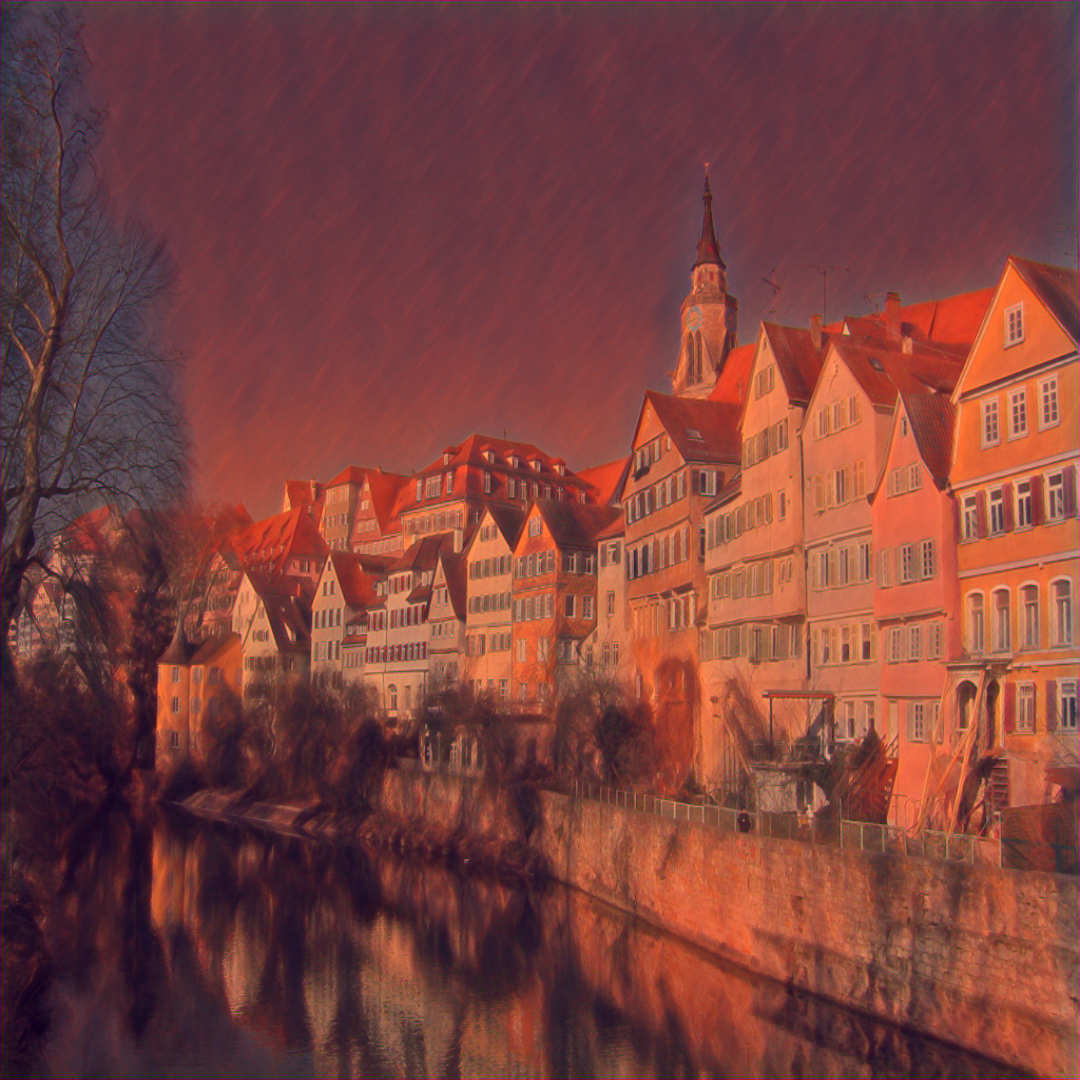

In [11]:
Image.open('/kaggle/working/final_output.png')

In [ ]:
import json

with open('/kaggle/working/history.json', 'w') as f:
    json.dump(history, f)

from IPython.display import FileLink
FileLink(r'history.json')

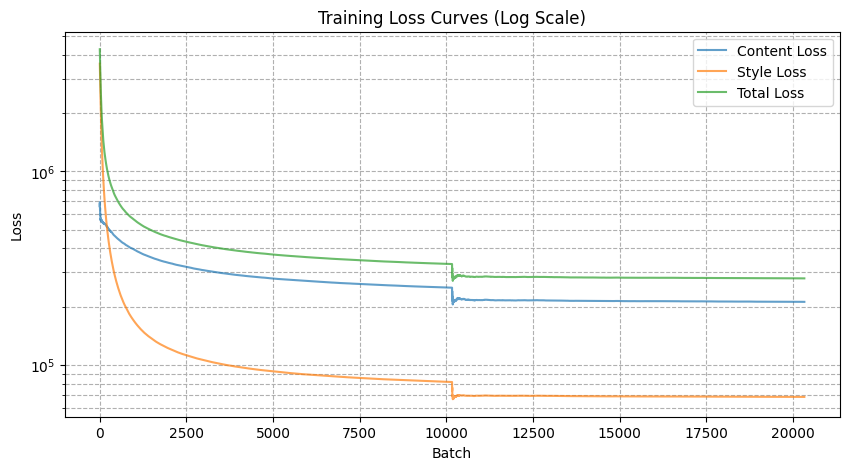

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(history["content_loss"], label="Content Loss", alpha=0.7)
plt.plot(history["style_loss"], label="Style Loss", alpha=0.7)
plt.plot(history["total_loss"], label="Total Loss", alpha=0.7)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss Curves (Log Scale)")
plt.legend()
plt.grid(True, which="both", linestyle="--")

plt.savefig('loss_plot.png', dpi=300, bbox_inches='tight')

plt.show()